<a href="https://colab.research.google.com/github/opinner/Articles/blob/main/Articles/IBSCO_data_in_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Run this notebook in [Google Colab](https://colab.research.google.com/drive/1FM_jlqs4E_h2hbBNaNV2sgH1F1A0GC0j?usp=sharing) or view it on [my personal GitHub page](https://github.com/opinner/Articles/blob/main/Articles/IBSCO_data_in_Python.ipynb).

In [1]:
# Install missing packages in google colab, if you want to run the code online
!pip install rioxarray
!pip install cmocean
!pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 780.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.9/421.9 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 77.5 MB/s eta 0:00:00


In [2]:
import rioxarray
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.path as mpath
import cmocean as cm

In [3]:
# dowload IBSCO data from pangea
!wget https://download.pangaea.de/dataset/937574/files/IBCSO_v2_ice-surface_WGS84.tif

--2024-07-17 10:37:43--  https://download.pangaea.de/dataset/937574/files/IBCSO_v2_ice-surface_WGS84.tif
Resolving download.pangaea.de (download.pangaea.de)... 134.1.2.172
Connecting to download.pangaea.de (download.pangaea.de)|134.1.2.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57162667 (55M) [image/tiff]
Saving to: ‘IBCSO_v2_ice-surface_WGS84.tif’

IBCSO_v2_ice-surfac 100%[===================>]  54.51M  13.3MB/s    in 5.7s    

2024-07-17 10:37:50 (9.64 MB/s) - ‘IBCSO_v2_ice-surface_WGS84.tif’ saved [57162667/57162667]



In [4]:
# check if data is now in local files
! ls

IBCSO_v2_ice-surface_WGS84.tif	sample_data


In [5]:
# Open the raster data
input_file = './IBCSO_v2_ice-surface_WGS84.tif'
ibsco_data = rioxarray.open_rasterio(input_file)

# Define the bounds in lat, lon coordinates for the subset
min_lon = -65
max_lon = -15
min_lat = -80
max_lat = -60

# Clip the data using the defined bounds
subset = ibsco_data.rio.clip_box(minx=min_lon, miny=min_lat, maxx=max_lon, maxy=max_lat)
#these values are really close to but not exactly the same as manually defined bounds
left, bottom, right, top = subset.rio.bounds()
subset_data = subset[0, :, :] # select the one (and only) band in the tif file

In [6]:
def setup_curved_map_shape():
    """
    Sets up a high-resolution South Polar Stereographic projection map with specified latitude and longitude extents.

    This function creates a plot with a South Polar Stereographic projection. It defines the projection, sets the extent
    of the map, and adjusts the boundary of the map to fit within the specified latitude and longitude limits. The resolution
    for computing great circles is increased for finer details. Because I was lazy, this docstring was written by ChatGPT.

    Returns:
        tuple: A tuple containing the figure and axis objects (fig, ax) for the created map.

    Example:
        fig, ax = setup_curved_map_shape()
        ax.coastlines()
        plt.show()
    """
    # Create the plot with a South Polar Stereographic projection
    # Define the projection for a high-resolution South Polar Stereographic map
    central_longitude = np.round(np.mean([min_lon, max_lon]), -1)
    projection = ccrs.SouthPolarStereo(central_longitude=central_longitude)

    # Increase the resolution in the computation of great circles
    # see https://stackoverflow.com/questions/60685245/plot-fine-grained-geodesic-with-cartopy/60724892#comment137539434_60724892
    # if we later run ax.set_boundary() this causes the boundary to be smooth without unwanted corners.
    projection.threshold = 1e3

    fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=projection))
    ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

    # Define the limits for the x-axis and y-axis of the map
    xlim = [min_lon, max_lon]  # longitude
    ylim = [min_lat, max_lat]  # latitude

    # Define a rectangular path for the map extent using matplotlib's Path object
    rect = mpath.Path([[xlim[0], ylim[0]], [xlim[1], ylim[0]], [xlim[1], ylim[1]], [xlim[0], ylim[1]], [xlim[0], ylim[0]]])

    # Transform the rectangular path to the data coordinate system
    proj_to_data = ccrs.PlateCarree()._as_mpl_transform(ax) - ax.transData
    rect_in_target = proj_to_data.transform_path(rect)

    # Set the boundary of the map using the transformed rectangular path
    ax.set_boundary(rect_in_target)

    return fig, ax

In [7]:
def plot_shaded_topography(fig, ax):
    """
    Plots shaded topography and bathymetry on a map with hill shading and contours.

    This function adds shaded relief and bathymetry to an existing map plot. It uses hill shading to create a 3D effect
    and overlays bathymetric data. Contour lines are added to highlight specific depth levels in the bathymetric data.
    Because I was lazy, this docstring was also written by ChatGPT.

    Args:
        fig (matplotlib.figure.Figure): The figure object to plot on.
        ax (matplotlib.axes._subplots.AxesSubplot): The axis object to plot on.

    Example:
        fig, ax = setup_curved_map_shape()
        plot_shaded_topography(fig, ax)
        plt.show()

    Note:
        Ensure the variables `subset_data`, `left`, `right`, `bottom`, `top`, and `subset` are defined in the appropriate scope when calling this function.
    """
    # Define direction of light source
    ls = mcolors.LightSource(azdeg=315, altdeg=45)

    # Plot and shade a base layer
    shade_only = np.array(subset_data)
    shade_only = shade_only.astype(float)  # Ensure float type

    # Compute hill shading
    shade = ls.hillshade(shade_only, vert_exag=0.1)

    # Plot the shaded relief using imshow
    # interpolation = 'none' is needed for good looking exports to svg or pdf
    ax.imshow(shade, extent=(left, right, bottom, top), transform=ccrs.PlateCarree(), origin='upper', cmap=cm.cm.gray, interpolation='none')

    # Use imshow to plot the bathymetry (negative values)
    bathymetry = np.where(subset_data >= 0, np.nan, subset_data)
    im = ax.imshow(bathymetry, extent=(left, right, bottom, top),
                   transform=ccrs.PlateCarree(),
                   origin='upper', cmap=cm.cm.ice,
                   vmin=-5000,
                   interpolation='none')

    # Add colorbar for bathymetry
    cbar = plt.colorbar(im, ax=ax, orientation='vertical')
    cbar.set_label('Bathymetry (m)')

    # Prepare data for hill shading only below 0 with transparency
    shade_only = np.where(subset_data > 0, np.nan, subset_data)
    shade_only = shade_only.astype(float)  # Ensure float type

    # Compute hill shading with transparency
    shade = ls.hillshade(shade_only, vert_exag=0.01, fraction=0.01)

    # Create a colormap that goes from fully transparent to black with some transparency
    transparent = mcolors.colorConverter.to_rgba('white', alpha=0)
    black = mcolors.colorConverter.to_rgba('black', alpha=0.3)
    custom_shading_cmap = mcolors.LinearSegmentedColormap.from_list('rb_cmap', [transparent, black], 512)

    # Use imshow to shade bathymetry
    ax.imshow(shade,
              extent=(left, right, bottom, top),
              transform=ccrs.PlateCarree(),
              origin='upper',
              cmap=custom_shading_cmap,
              interpolation='none' #ensures the full image resolution is saved
              )

    # Extract coordinates for contour plotting
    lon, lat = subset.x.values, subset.y.values
    lon_grid, lat_grid = np.meshgrid(lon, lat)

    # Create contour lines for specified depths, in the bathymetry map as well as in the colormap
    levels = [-4000, -3000, -2000, -1000]
    contour = ax.contour(lon_grid, lat_grid, subset_data, transform=ccrs.PlateCarree(),
                         levels=levels, colors="white", linestyles="solid", linewidths=0.5)
    cbar.add_lines(levels, colors=len(levels)*["w"], linewidths=1)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

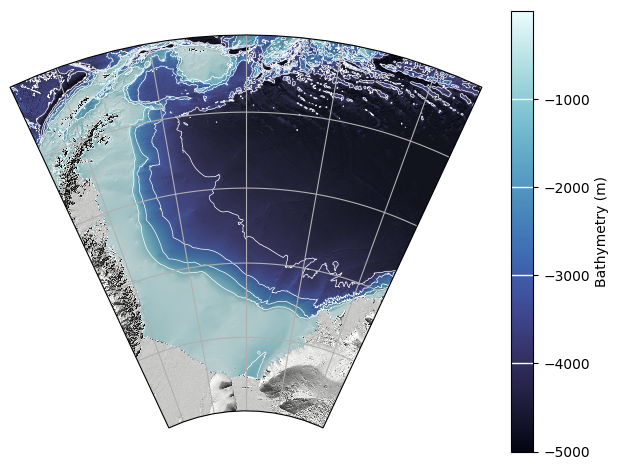

In [8]:
fig, ax = setup_curved_map_shape()
plot_shaded_topography(fig,ax)

gl = ax.gridlines(
    xlocs = np.arange(-60,-10,10),
    ylocs = np.arange(-80,-60,4),
    # This is commented out as it does not produce the desired results
    # as not all grid lines will be labelled
    # draw_labels=["top", "left", "x", "y"],
    dms=True,
    x_inline=False,
    y_inline=False
    )

fig.tight_layout()

# If you run this on google colab, download the image as follows:
plt.savefig("map.png", bbox_inches='tight', dpi = 400)
# plt.savefig("map.svg")

#from google.colab import files
#files.download("map.png")
# files.download("map.svg")